## Preprocessing 

In [1]:
import nltk
print(nltk.data.find('tokenizers/punkt'))# this address is used in the prepprocess_text_random_forest.py file in the nltk_data_path variable


C:\Users\aj281\AppData\Roaming\nltk_data\tokenizers\punkt


In [1]:
# Step 1: Import the function from your .py file
from preprocess_text_random_forest import run_preprocessing

# Step 2: Call the function — it will return the processed DataFrame
df = run_preprocessing()

# Step 3: Now you can use df for your Random Forest or any further steps
df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aj281\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aj281\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 71/71 [00:35<00:00,  2.00it/s]


,date,text,is_retweet,lang,sentiment,preprocess_text
0,2021-04-12 18:56:10,The Why Behind Microsoft’s $19 Billion Nuance ...,False,en,neutral,The Why Behind Microsoft s Billion Nuance Buy ...
1,2021-04-12 18:55:48,Make a change and an impart on yourself and ot...,False,en,neutral,Make a change and an impart on yourself and ot...
2,2021-04-12 18:55:27,What are the biggest shitcoins? crypto btc bnb...,False,en,neutral,What are the biggest shitcoins crypto btc bnb ...
3,2021-04-12 18:55:22,crypto bitcoin cryptocurrency blockchain btc e...,False,en,neutral,crypto bitcoin cryptocurrency blockchain btc e...
4,2021-04-12 18:55:01,[1D] Bitcoin market is weakly trending up curr...,False,en,negative,Bitcoin market is weakly trending up current m...


## Vectorization of the text

In [3]:
X=df['preprocess_text']
y=df['sentiment']

n=len(X)

split_index=int(n*0.8)
# Split the data into training and testing sets
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]

#sklearn train_test_split is not used because it splits randomly and we want to keep the order of the data for the time series modeling

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(
    stop_words='english',
    lowercase=True, 
    max_features=1000,
    min_df=0.01,
    max_df=0.9,
)



X_train_tfidf=vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("Shape of the feature matrix X: ",X_train_tfidf.shape)
print("Shape of the target vector Y: ",y_train.shape)


Shape of the feature matrix X:  (565348, 171)
Shape of the target vector Y:  (565348,)


## Random Forest model

In [9]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint
import time

# ✅ Step 1: Define the parameter distribution (no n_estimators here!)
param_dist = {
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 4),
    'criterion': ['gini'],
    'bootstrap': [True]
}

# ✅ Step 2: Initialize classifier with n_estimators (will be controlled by halving)
rf = RandomForestClassifier(random_state=42, n_jobs=1, class_weight='balanced') # since there is a class imbalance in the dataset, we will use class_weight='balanced' to balance the classes

# ✅ Step 3: Halving Random Search CV
halving_search = HalvingRandomSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    factor=3,
    resource='n_estimators',   # We will vary this automatically
    max_resources=150,         # Final model will train with 150 trees
    min_resources=30,          # Start with 30 trees
    cv=2,
    scoring='f1_macro',        # Use f1_macro for imbalanced classes
    random_state=42,
    n_jobs=2,
    verbose=2
)

halving_search.fit(X_train_tfidf, y_train)
best_model = halving_search.best_estimator_
print("Best Parameters:", halving_search.best_params_)
y_pred = best_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 30
max_resources_: 150
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 5
n_resources: 30
Fitting 2 folds for each of 5 candidates, totalling 10 fits
----------
iter: 1
n_candidates: 2
n_resources: 90
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 48, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 90}
              precision    recall  f1-score   support

    negative       0.45      0.41      0.43     26243
     neutral       0.57      0.85      0.68     46339
    positive       0.90      0.64      0.74     68755

    accuracy                           0.66    141337
   macro avg       0.64      0.63      0.62    141337
weighted avg       0.71      0.66      0.67    141337



Confusion Matrix:
[[10790 11848  3605]
 [ 5656 39164  1519]
 [ 7672 17328 43755]]


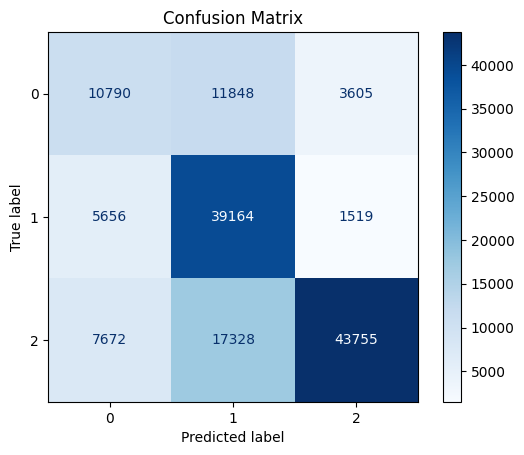

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
